<a href="https://colab.research.google.com/github/neonithinar/ML_and_DL_learning_materials_and_tryouts/blob/master/TF_tutorial_Text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic text classification
This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.

In [1]:
import matplotlib.pyplot as plt
import os, re
import shutil
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.4.1


## sentiment analysis from IMDb
binary classification task


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')


84131840/84125825 [==============================] - 4s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'train', 'test']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_pos.txt',
 'unsupBow.feat',
 'urls_neg.txt',
 'neg',
 'unsup']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset
load the dataset from directory

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [8]:
batch_size = 32
seed = 42

raw_train_ds = preprocessing.text_dataset_from_directory('aclImdb/train', batch_size= batch_size,
                                                         validation_split = 0.2, subset= 'training', seed = seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [9]:
# print out a few examples

for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review: ", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])
    

Review:  b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0
Review:  b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get 

 The above review contains html tags like ```<br></br>```
 we also need to check the class names


In [10]:
print("label 0:", raw_train_ds.class_names[0], "\n Label 1:", raw_train_ds.class_names[1])

label 0: neg 
 Label 1: pos


Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [11]:
raw_val_ds = preprocessing.text_dataset_from_directory('aclImdb/train', 
                                                       batch_size = batch_size, seed= seed, validation_split = 0.2, subset = 'validation')

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = preprocessing.text_dataset_from_directory(
    'aclImdb/test', batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [13]:
def custorm_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.


In [14]:
max_features = 10000
sequence_length = 25

vectorize_layer = TextVectorization(standardize= custorm_standardization, 
                                    max_tokens = max_features, output_mode = 'int', 
                                    output_sequence_length = sequence_length)


Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.
Note: it's important to only use the trainig data while calling adapt. using the test data will leak information

In [15]:
# make a text only dataset without labels, then call adapt
train_txt = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_txt)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [24]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16]])>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


In [28]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
#Create train, test and validation data

train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)


These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
Ttest_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


## Creating the model

In [21]:
embedding_dim = 16
model = keras.models.Sequential([
                                layers.Embedding(max_features + 1, embedding_dim), 
                                layers.Dropout(0.2), 
                                layers.GlobalAveragePooling1D(), 
                                layers.Dropout(0.2), 
                                layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss = losses.BinaryCrossentropy(from_logits= True), optimizer= 'adam', metrics = tf.metrics.BinaryAccuracy(threshold= 0.0))

In [23]:
history = model.fit(train_ds, validation_data=  val_ds, epochs= 10)


Epoch 1/10
625/625 [==============================] - 12s 14ms/step - loss: 0.6821 - binary_accuracy: 0.5969 - val_loss: 0.6351 - val_binary_accuracy: 0.6698
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6017 - binary_accuracy: 0.7160 - val_loss: 0.5777 - val_binary_accuracy: 0.7048
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5277 - binary_accuracy: 0.7617 - val_loss: 0.5486 - val_binary_accuracy: 0.7176
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4795 - binary_accuracy: 0.7914 - val_loss: 0.5360 - val_binary_accuracy: 0.7224
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4434 - binary_accuracy: 0.8087 - val_loss: 0.5322 - val_binary_accuracy: 0.7272
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4181 - binary_accuracy: 0.8238 - val_loss: 0.5343 - val_binary_accuracy: 0.7286
Epoch 7/10
625/625 [==============================] - 3s 4ms/s

In [29]:
model.evaluate(test_ds)

782/782 [==============================] - 8s 10ms/step - loss: 0.5932 - binary_accuracy: 0.7092


[0.5931658744812012, 0.7092000246047974]

### Trying out some GRU layers for this task

In [36]:
model = keras.models.Sequential([
                                layers.Embedding(max_features + 1, embedding_dim), 
                                 layers.GRU(128, return_sequences= True),
                                 layers.GRU(128), 
                                 layers.Dense(1, activation= 'sigmoid')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
gru_2 (GRU)                  (None, None, 128)         56064     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 315,281
Trainable params: 315,281
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss = losses.BinaryCrossentropy(from_logits= True), optimizer= 'adam', metrics = tf.metrics.BinaryAccuracy(threshold= 0.0))

In [38]:
history = model.fit(train_ds, validation_data=  val_ds, epochs= 10)


Epoch 1/10
625/625 [==============================] - 8s 8ms/step - loss: 0.6558 - binary_accuracy: 0.4951 - val_loss: 0.5525 - val_binary_accuracy: 0.5076
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4751 - binary_accuracy: 0.4951 - val_loss: 0.5648 - val_binary_accuracy: 0.5076
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3932 - binary_accuracy: 0.4951 - val_loss: 0.6575 - val_binary_accuracy: 0.5076
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3223 - binary_accuracy: 0.4951 - val_loss: 0.8035 - val_binary_accuracy: 0.5076
Epoch 5/10
625/625 [==============================] - 5s 7ms/step - loss: 0.2445 - binary_accuracy: 0.4951 - val_loss: 0.9440 - val_binary_accuracy: 0.5076
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.1941 - binary_accuracy: 0.4951 - val_loss: 1.0383 - val_binary_accuracy: 0.5076
Epoch 7/10
625/625 [==============================] - 5s 7ms/ste

 so this one is really worse! maybe something to do with the preprocessing of the data and how it actually is fed into the network/ for the timebeing, we will continue with the model

In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

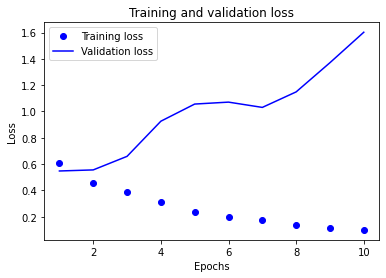

In [39]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

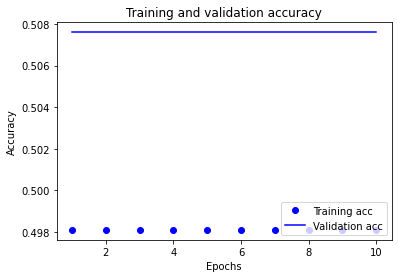

In [40]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model.

If you want to make the model capable of procesing raw strings without preprocessing it , we can use the text vectorization within the model


In [42]:
export_model = keras.Sequential([
                                 vectorize_layer, 
                                 model, 
                                 layers.Activation('sigmoid')
])

export_model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])


In [43]:
#model evaluation
export_model.evaluate(raw_test_ds)

782/782 [==============================] - 11s 12ms/step - loss: 0.6808 - accuracy: 0.5037


[0.6815837621688843, 0.5]

#### INference on new data

In [44]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.5013297],
       [0.5002603],
       [0.5002038]], dtype=float32)